<div class="alert alert-block alert-info">
This tutorial is only for your fun / edification. No need to answer any lab questions you may find. 
</div>

# Neural networks, Part 4

## *Human Statistical Learning: a publication-level example*
---

This notebook contains a nearly-complete implementation of a full training and analysis pipeline for a real domain of research in cognitive science: human **statistical learning**. 

I will give an overview of this domain in class. 

The basic idea is that if you expose a human (infant, child, or adult) to a stream of seemingly random syllables, but actually there is statistical structure to the syllables, they become sensitive to those statistics. 

In a classic study in *Science* in 1996, Jenny Saffran, Elissa Newport, and Dick Aslin presented 4-month-old infants with a 2-minute stream of syllables. They were auditory, but we can get a sense of how strange the input was by spelling it out (I've addded a few spaces to allow it to wrap, but there were no pauses in the input in the study):

`tokibugikobagopilatipolutokibu gopilatipolutokibugikobagopila gikobatokibugopilatipolugikobatipolugikobatipolugopila tipolutokibugopilatipolutokibugopilatipolutokibugopilagikoba tipolutokibugopilagikobatipolugikobatipolugikobatipolu tokibugikobagopilatipolugikobatokibugopila`

Although it sounds essentially random, it has 4 "word-like" patterns that repeat: `tokibu`, `gikoba`, `gopila`, `tipolu`. The words were in random order, with the constraint that a word could not repeat immediately. This mean that *transitional probabilities* were 1.0 within words (`ki` always follows `to`, and `bu` always follows `ki`) but 0.33 between words (`bu` was equally likely to be followed by `gi`, `go`, or `ti`). 

After 2 minutes of exposure, Saffran et al. tested babies' sensitivity to the statistical structure. They did this by sometimes playing one of the words from the mini-language over a speaker (e.g., the infant might hear `tokibu` repeated over and over), and sometimes playing a "part-word" made up of the last syllable of one word and the first 2 syllables of another (e.g., `lagiko`). They then measured how long the infants looked at the speaker while it was playing words vs. part-words. On average, infants looked significnatly longer at part-words (a so-called *novelty preference*). 

With adults, we can just play them a word and a part-word and ask 'which sounds more like what you were hearing earlier?'

French et al. (2011) proposed a way to standardize across statistical learning studies with humans and computer models: a metric they called **proportion better**. Here you take your measure for words and subtract your measure for part-words (or vice versa when subjects show a novelty preference) and then divide by their sum. 

We can apply this with looking time by taking the difference in looking time over the sum: $(7.6-6.8) / (7.6+6.8) = 0.06$. 

With a neural network trained to process these kinds of items, we can look at how much error it makes predicting words vs. part-words. 

We can also use the amount of error to simulate trial-by-trial performance. We can take the error for a word, and compare it to the error for each part-word. Every time error is lower on the word, that's a case where the word is better. We do all the word-to-part-word comparisons and calculate **word choices**. 



<div class="alert alert-block alert-info">
    
    
### Note: 'statistical learning' means different things in different fields
    
There is an unfortunate interdisciplinary jargon conflict here. In computer science / engineering / artificial intelligence, 'statistical learning' is more or less a synonym for 'machine learning'. Psychologists appropriated this term to mean learning that appears to happen in an implicit way, based on statistical structure in some kind of information.

</div>


---

## Simulating statistical learning

So let's work towards trying to simulate performance in this task. We could try using a feedforward network or a simple recurrent network. 



## Feedforward network

Here's a schematic of a feedforward network (FFN). The dots within layers indicate that there could be arbitrarily many nodes within each layer. Note that connections only go 'forward', from the input towards the output. FFNs are typically trained just to do input-output mappings such as 'evaluate the truth value of these inputs with respect to the XOR function' or 'classify this image as a dog or a cat'. However, we could also try to train an FFN on sequences; for example, we could make the input-ouput mapping 'given the current input, try to output the next element in the sequence'. The FFN will be limited to learning the transitional probabilities from one element to another; it will not be able to learn to make predictions based on the previous input and the current input, for example. 

<div>
<img src="figs/ff-tikz.png" width="500"/>
</div>

## Making it a Simple Recurrent Network (SRN)

To make an SRN, we add **Context** nodes that provide additional inputs to the hidden layer at each time step. These special nodes get their states via special *copy-back* connections from the hidden nodes. These are 1-to-1 connections: $Hid_1$ connects only to $Context_1$, $Hid_2$ connects only to $Context_2$, etc. ($Hid_n$ connects only to $Context_n$). The weights on the copy-back links are always 1.0 so that we simply copy the activation values of the hidden layer at the previous time step. 

However, the context nodes are fully connected to the hidden layer -- every context node has a trainable, weighted connection to every hidden node. 

<div>
<img src="figs/srn-tikz.png" width="500"/>
</div>

This gives the network the capability of developing senstivity to sequential information. It is not limited to just one step back in time, though, because it can adjust the context-to-hidden weights (as well as input-to-hidden weights) such that it can preserve information going back possibly many steps, in a context-sensitive way (here 'context' is meant in its generic sense, not just with respect to the context nodes). 

The SRN will be able to learn not just simple transitional probabilities between adjacent elements in sequences, but also dependencies based on several time steps. For example, if A can be followed by B, C, or D, but then the next element after that is always E (e.g., ABE, ACE, ADE), the network will learn that contingency readily (even if B, C and E can be followed by other items in different contexts, e.g., JBF, KBH, LCM, etc.). 

Jeff Elman originally developed SRNs in the late 1980s, with the first publications in 1990 and 1991. He trained them to do *next-item prediction*: given the current element in a sequence, predict the next one. This could be 'predict the next phoneme given the current phoneme' or 'predict the next word given the current word'. This is the basis for contemporary 'large language models' (like Chat-GPT) -- they also do next-word prediction.

Why are they called *simple* recurrent networks? This is in contrast to (fully) recurrent networks, that hold store many, many previous states (in some cases many thousands). There are special algorithms for training them (*backpropagation through time*, or BPTT), but they are very memory intensive and difficult to analyze and understand. The SRN is simple in the sense that it just holds onto 1 time step, and copies it essentially into the input. This allows the weighted connections (all the solid lines in the diagram above) to be trained using regular backpropagation of error. It's a truly simple innovation, but it has proved to be incredibly powerful. 

<div class="alert alert-block alert-info">

### A note: Assessing learning
    
In the statistical learning task described above, it is impossible to perform perfectly and make no errors. An optimal, ideal system would make no errors *within* words, where the second and third syllables are perfectly predictable, but could not perfectly predict what comes next. This is because after the final syllable of a word, the next syllable will be the first syllable of one of the other three words, selected at random. Thus, an optimal, ideal system would make no error within words, but the best it could do at word boundaries would be to activate the first syllables of the other three words equally.
    
</div>


### Some details about the SRN architecture

We will build an SRN below. There are a few details to highlight.

- We will train a network by presenting it with 'symbols' that represent different syllables. For example, if we have 12 syllables (like Saffran et al. did, with their 4 three-syllable words), we would have 12 input nodes. Each would stand for a different syllable. We would also then have 12 outputs -- again, one for each syllable. The network's task will be to try to activate the output node for the next syllable in response to the input node for the current syllable. 

- We will use $tanh$ (hyperbolic tangent) activation function in the hidden layer, like we did for the XOR network we trained in the previous notebook. 

- We will use the $sigmoid$ activation function for the output layer, again like we did for XOR. 

- We will include a bias node that has a connection to every hidden node. If you explore the code, you will find that the network will still learn just fine if you eliminate it; however, it tends to learn faster with it.

- We will use an extremely similar weight-update algorithm as in the single-output XOR network, even though we will have 12 outputs. The next section explains this. 

---

<div class="alert alert-block alert-info">

### *Skip this section if you are not interested in this level of detail.*
    
### Understanding error signal in the context of sigmoid activation and *Cross-Entropy Loss*

In a neural network with sigmoid activation and cross-entropy loss, the calculation of the error signal is quite straightforward and elegant due to the properties of these functions.

1. **Sigmoid Activation Function**: 
   The sigmoid function, defined as $\sigma(x) = \frac{1}{1 + e^{-x}}$, outputs a value between 0 and 1. This output is typically interpreted as the probability of the positive class in binary classification.

2. **Cross-Entropy Loss**: 
   For binary classification, cross-entropy loss is defined as:
   $$ L = -[y \log(p) + (1-y) \log(1-p)] $$
   where $y$ is the true label (0 or 1), and $p$ is the predicted probability (output of the sigmoid function).

3. **Derivative of Cross-Entropy Loss**:
   The derivative of the cross-entropy loss with respect to the input of the sigmoid function (which is the raw output of the network before applying the sigmoid) simplifies beautifully when combined with the derivative of the sigmoid function itself. The derivative of the sigmoid function $\sigma(x)$ is $\sigma(x) (1 - \sigma(x))$. Applying the chain rule, the derivative of the loss with respect to the raw output ends up being the simple difference between the predicted probability and the actual target:
   $$ p - y $$

This simplification, where the error signal is just the difference between the predicted probability and the actual target, is one of the key reasons why the combination of sigmoid activation and cross-entropy loss is popular, especially for binary classification tasks. It leads to a more stable and efficient training process compared to using mean squared error with sigmoid activation, as the gradient is more responsive even when the predicted probability is close to the actual label.

Thus, when the error signal is calculated as `output_vec - target_vec` in the backpropagation algorithm, it effectively uses the derivative of the cross-entropy loss with respect to the network's output. This approach provides the correct gradient for weight updates in a network using sigmoid outputs and cross-entropy loss.

**However, we are not doing simple binary classification -- we have 12 possible outputs. How does this still work?**

### Cross-Entropy Loss for *Multi-Class* Classification

In a neural network designed for multi-class classification with 12 categories, using sigmoid activation for each category and cross-entropy loss, the error signal computation is slightly more complex than in binary classification but still maintains a straightforward approach.

#### Sigmoid Activation Function:
In multi-class classification with 12 categories, each output neuron corresponds to one category. The sigmoid function is applied to each neuron's output, giving a probability-like value between 0 and 1. However, it's important to note that these values don't necessarily sum up to 1 across all categories (unlike softmax activation which is often used in multi-class classification).

#### Cross-Entropy Loss for Multi-Class Classification:
The cross-entropy loss in multi-class classification is a generalization of the binary case. It's actually simpler. It is defined as:

$$ L = -\sum_{c=1}^{n} y_c \log(p_c) $$

where $ n $ is the number of classes (12 in our case), $ y_c $ is 1 if the true category is $ c $ and 0 otherwise (one-hot encoded), and $ p_c $ is the predicted probability for category $ c $. This loss function calculates a separate loss for each category and then sums them up.

However, 

#### Derivative of Cross-Entropy Loss:
Just as in the binary case, the error signal in the multi-class scenario can be calculated elegantly. The derivative of the cross-entropy loss with respect to the input of the sigmoid function for each category is the difference between the predicted probability and the actual target for that category:

$$ p_c - y_c $$

for each category $ c $.

Therefore, in a 12-category classification task, the error signal for each category (neuron) in the output layer is the difference between the neuron's activation (interpreted as the predicted probability for that category) and the corresponding value in the one-hot encoded target vector. This error signal is then used in backpropagation to update the weights.

However, we can also keep the code we used previously; the binary case actually works fine so long as we sum the loss over each output node. This works because the targets (syllables) are one-hot encoded, representing multiple classes (different syllables), and the network predicts the probability of each class (syllable) independently. Let's clarify this:

#### Multi-Class Setting:
Each syllable in our lexicon is a separate class or category. The network essentially predicts the probability of each syllable being the next one in the sequence. The output layer has as many nodes as there are unique syllables, with each node corresponding to a particular syllable.

#### Sigmoid Activation:
The sigmoid function is applied to the input of each output node, providing a probability-like score for each syllable. Unlike softmax, which normalizes outputs across all classes to sum up to 1, the sigmoid function treats each output independently. This means the network predicts the likelihood of each syllable independently, not as a mutually exclusive set.

#### Cross-Entropy Loss for Multi-Class (One-Hot Targets):
The cross-entropy loss is calculated for each neuron (syllable) independently and then summed up. This is appropriate for our case where each target is a one-hot encoded vector, representing the correct syllable. The loss function penalizes the network for the difference between its predicted probability and the actual target (1 for the correct syllable, 0 for others). 

#### Error Signal:
For each node, the error signal (used in backpropagation) is the difference between the predicted probability (output of the sigmoid function) and the actual target in the one-hot encoded vector. This guides the network to increase the probability for the correct syllable and decrease it for the others.

Thus, even though the setup looks similar to binary classification, it's actually a multi-class classification where each class (syllable) is treated independently. The network learns to predict the likelihood of each syllable in the lexicon, and the cross-entropy loss function is an effective choice for this kind of problem.

    
**Summary**. This process efficiently directs the network to adjust its predictions towards the actual distribution of the categories, provided by the one-hot encoded target vectors. The cross-entropy loss function in conjunction with sigmoid activation remains an effective choice for multi-class classification due to its ability to penalize incorrect predictions robustly and guide the network towards accurate category probabilities.

</div>

### Import needed libraries

In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time 
from IPython.display import clear_output

## Plotting routines

In [30]:
def plot_training_progress(loss_history, word_choices_history, prop_better_history, \
                           combined_input_target_output_matrix, combined_hidden_context_matrix, \
                           W_input_hidden, W_context_hidden, W_hidden_output, epoch, loss_lexicon_history=None):

    clear_output(wait=True)
    fig = plt.figure(figsize=(15, 8))

    # Create a GridSpec for layout
    # gs = fig.add_gridspec(5, 3, width_ratios=[2, 1, 0.1], height_ratios=[3, 2, 5, 5, 5])
    gs = fig.add_gridspec(5, 4, width_ratios=[4, 4, 2, 0.1], height_ratios=[3, 2, 5, 5, 5])

    # Plot loss
    ax_loss = fig.add_subplot(gs[:, 0])
    ax_loss.plot(range(1, len(loss_history) + 1), loss_history, label='Training')
    if loss_lexicon_history is not None:
        # Plot red points for loss_lexicon (test loss)
        epochs_with_test = [i for i, loss in enumerate(loss_lexicon_history) if not np.isnan(loss)]
        test_losses = [loss for loss in loss_lexicon_history if not np.isnan(loss)]
        ax_loss.scatter(epochs_with_test, test_losses, color='violet', s=25, label='Testing', zorder=5)
    # Adding grey dashed lines at y=0
    ax_loss.axhline(y=0, color='lightgrey', linestyle='--')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Cross-Entropy Loss')
    ax_loss.set_title(f'Loss vs Epochs, EPOCH {epoch}')
    ax_loss.legend()
    
    # New subplot for proportion_better and word_choices
    ax_tests = fig.add_subplot(gs[:, 1])
    if prop_better_history is not None:
        #ax_tests.plot(range(1, len(prop_better_history) + 1), prop_better_history, 'r.', markersize=10, label='Proportion Better')
        # Plotting both points and a connecting line
        # ax_tests.plot(range(1, len(prop_better_history) + 1), prop_better_history, 'r.-', label='Proportion Better', markersize=5)  # Connecting line with points
        epochs = range(1, len(prop_better_history) + 1)
        ax_tests.plot(epochs, prop_better_history, 'r.', label='Proportion Better', markersize=5)
        # Plotting line separately, ignoring NaNs
        non_nan_indices = ~np.isnan(prop_better_history)
        ax_tests.plot(np.array(epochs)[non_nan_indices], np.array(prop_better_history)[non_nan_indices], 'r-')  # Connecting line for non-NaN segments

    if word_choices_history is not None:
        epochs = range(1, len(word_choices_history) + 1)
        ax_tests.plot(range(1, len(word_choices_history) + 1), word_choices_history, 'b.', markersize=5, label='Word Choices')
        # Plotting line separately, ignoring NaNs
        non_nan_indices = ~np.isnan(word_choices_history)
        ax_tests.plot(np.array(epochs)[non_nan_indices], np.array(word_choices_history)[non_nan_indices], 'b-')  # Connecting line for non-NaN segments
    # Adding grey dashed lines at y=0 and y=0.5
    ax_tests.axhline(y=0, color='mistyrose', linestyle='--')
    ax_tests.axhline(y=0.5, color='skyblue', linestyle='--')
    ax_tests.set_xlabel('Epoch')
    ax_tests.set_ylabel('Test Metrics')
    ax_tests.set_title('Test Performance Metrics')
    ax_tests.legend()

    # Plotting the heatmap for Input, Target, and Output
    ax_input_target_output_heatmap = fig.add_subplot(gs[0, 2])
    input_target_output_heatmap = ax_input_target_output_heatmap.imshow(combined_input_target_output_matrix, cmap='hot', interpolation='nearest', aspect='auto')
    ax_input_target_output_heatmap.set_title('Input, Target & Output Vectors')
    ax_input_target_output_heatmap.set_yticks([0, 1, 2])
    ax_input_target_output_heatmap.set_yticklabels(['Input', 'Target', 'Output'])
    ax_input_target_output_heatmap_cbar = fig.add_subplot(gs[0, 3])
    plt.colorbar(input_target_output_heatmap, cax=ax_input_target_output_heatmap_cbar)

    # Plot combined hidden-context heatmap
    ax_hidden_context_heatmap = fig.add_subplot(gs[1, 2])
    hidden_context_heatmap = ax_hidden_context_heatmap.imshow(combined_hidden_context_matrix, cmap='hot', interpolation='nearest', aspect='auto')
    ax_hidden_context_heatmap.set_title('Hidden & Context States')
    ax_hidden_context_heatmap.set_yticks([0, 1])
    ax_hidden_context_heatmap.set_yticklabels(['Hidden', 'Context'])
    ax_hidden_context_heatmap_cbar = fig.add_subplot(gs[1, 3])
    plt.colorbar(hidden_context_heatmap, cax=ax_hidden_context_heatmap_cbar)

    # Plot input-to-hidden weight matrix heatmap
    ax_input_hidden_heatmap = fig.add_subplot(gs[2, 2])
    input_hidden_heatmap = ax_input_hidden_heatmap.imshow(W_input_hidden, cmap='hot', interpolation='nearest', aspect='auto')
    ax_input_hidden_heatmap.set_title('Input-to-Hidden Weights')
    ax_input_hidden_heatmap_cbar = fig.add_subplot(gs[2, 3])
    plt.colorbar(input_hidden_heatmap, cax=ax_input_hidden_heatmap_cbar)

    # Plot context-to-hidden weight matrix heatmap
    ax_context_hidden_heatmap = fig.add_subplot(gs[3, 2])
    context_hidden_heatmap = ax_context_hidden_heatmap.imshow(W_context_hidden, cmap='hot', interpolation='nearest', aspect='auto')
    ax_context_hidden_heatmap.set_title('Context-to-Hidden Weights')
    ax_context_hidden_heatmap_cbar = fig.add_subplot(gs[3, 3])
    plt.colorbar(context_hidden_heatmap, cax=ax_context_hidden_heatmap_cbar)

    # Plot hidden-to-output weight matrix heatmap
    ax_hidden_output_heatmap = fig.add_subplot(gs[4, 2])
    hidden_output_heatmap = ax_hidden_output_heatmap.imshow(W_hidden_output, cmap='hot', interpolation='nearest', aspect='auto')
    ax_hidden_output_heatmap.set_title('Hidden-to-Output Weights')
    ax_hidden_output_heatmap_cbar = fig.add_subplot(gs[4, 3])
    plt.colorbar(hidden_output_heatmap, cax=ax_hidden_output_heatmap_cbar)

    plt.tight_layout()
    plt.show()

## Network functions

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to process the lexicon and map syllables to indices
def process_lexicon(lexicon):
    unique_syllables = sorted(set(''.join(lexicon)))
    syllable_to_index = {syllable: i for i, syllable in enumerate(unique_syllables)}
    return unique_syllables, syllable_to_index

def initialize_network(lexicon, nhidden=None, method='normal', wmean=0, wsd=0.25):
    _, syllable_to_index = process_lexicon(lexicon)
    n_syllables = len(syllable_to_index)
    nhidden = nhidden or n_syllables

    if method == "uniform":
        W_input_hidden = np.random.randn(n_syllables, nhidden) * 0.01
        W_context_hidden = np.random.randn(nhidden, nhidden) * 0.01  # New weights
        W_hidden_output = np.random.randn(nhidden, n_syllables) * 0.01
        hidden_state = np.zeros(nhidden)
        W_bias_hidden = np.random.randn(nhidden) * 0.01  # Bias weights
    else:
        W_input_hidden = np.random.normal(wmean, wsd, (n_syllables, nhidden))
        W_context_hidden = np.random.normal(wmean, wsd, (nhidden, nhidden))
        W_hidden_output = np.random.normal(wmean, wsd, (nhidden, n_syllables))
        W_bias_hidden = np.random.normal(wmean, wsd, nhidden)
        hidden_state = np.zeros(nhidden)
        

    return W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state

def save_weights(W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, filename_prefix):
    np.save(f'{filename_prefix}_input_hidden.npy', W_input_hidden)
    np.save(f'{filename_prefix}_bias_hidden.npy', W_bias_hidden)
    np.save(f'{filename_prefix}_context_hidden.npy', W_context_hidden)
    np.save(f'{filename_prefix}_hidden_output.npy', W_hidden_output)
    print("Weights saved successfully.")
    # Example of saving weights
    # save_weights(W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, 'network_weights')


def load_weights(filename_prefix):
    W_input_hidden = np.load(f'{filename_prefix}_input_hidden.npy')
    W_bias_hidden = np.load(f'{filename_prefix}_bias_hidden.npy')
    W_context_hidden = np.load(f'{filename_prefix}_context_hidden.npy')
    W_hidden_output = np.load(f'{filename_prefix}_hidden_output.npy')
    print("Weights loaded successfully.")
    return W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output

    
#def binary_cross_entropy_loss(y_true, y_pred):
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))

def multi_cross_entropy_loss(y_true, y_pred):
    # Ensure small value is added to y_pred to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred))
    return loss

# Function to generate the sequence of words for an epoch
def generate_epoch_sequence(lexicon, frequency, lexbatch=None, no_repeat=True):
    epoch_sequence = []
    if lexbatch:
        for _ in range(lexbatch):
            batch = lexicon * frequency
            random.shuffle(batch)
            if no_repeat:
                # Ensure no repeated word at the boundary
                while batch[0] == epoch_sequence[-1]:
                    random.shuffle(batch)
            epoch_sequence.extend(batch)
    else:
        epoch_sequence = lexicon * frequency
        random.shuffle(epoch_sequence)
        if no_repeat:
            # Ensure no repeated word at the start
            while len(epoch_sequence) > 1 and epoch_sequence[0] == epoch_sequence[-1]:
                random.shuffle(epoch_sequence)

    # Convert the sequence of words into a sequence of letters
    letter_sequence = ''.join(epoch_sequence)
    return letter_sequence

# Function to encode words to input and target vectors
def encode_word(word, syllable_to_index):
    vec = np.zeros(len(syllable_to_index))
    vec[syllable_to_index[word]] = 1
    # vec[syllable_to_index[word[-1]]] = 1  # Encoding the last syllable as target
    return vec

# Function to calculate loss on a given sequence of words
def calculate_loss_on_sequence(sequence, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, \
                               syllable_to_index, hidden_state):
    total_loss = 0
    num_syllables = len(sequence) - 1  # Subtract 1 because the last syllable has no following syllable as a target

    for i in range(len(sequence) - 1):
        input_vec = encode_word(sequence[i], syllable_to_index)
        target_vec = encode_word(sequence[i + 1], syllable_to_index)
        _, output_vec = forward_pass(input_vec, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state)
        this_loss = cross_entropy_loss(target_vec, output_vec)
        total_loss += this_loss
        # print(f'\n#{sequence}\n\tINPUT {input_vec}\n\tTARGET {target_vec}\n\tOUTPUT {output_vec}\n\tthisLOSS {this_loss}, totLOSS {total_loss}')
    
    # time.sleep(4)
    average_loss_per_syllable = total_loss / num_syllables
    return average_loss_per_syllable
    # return total_loss

# Function to calculate error for individual word for all but last item, since target is not defined
def calculate_word_error(word, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, \
                         syllable_to_index, hidden_state):
    total_error = 0
    for i in range(len(word) - 1):
        input_vec = encode_word(word[i], syllable_to_index)
        target_vec = encode_word(word[i + 1], syllable_to_index)
        _, output_vec = forward_pass(input_vec, \
                                     W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state)
        total_error += cross_entropy_loss(target_vec, output_vec)
    return total_error

# Function to calculate word choices
def calculate_word_choices(lex_errors, comp_errors):
    word_better_count = 0
    total_comparisons = 0
    for lex_error, comp_error in zip(lex_errors, comp_errors):
        total_comparisons += 1
        if lex_error < comp_error:
            word_better_count += 1
    return word_better_count / total_comparisons if total_comparisons > 0 else 0


# Function to calculate proportion better
def prop_better_and_word_choices(lexicon, comparison_items, \
                                W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, \
                                syllable_to_index):
    # Calculate errors for each word in lexicon and comparison items
    lex_errors = [calculate_word_error(word, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, \
                                       syllable_to_index, np.zeros_like(hidden_state)) for word in lexicon]
    comp_errors = [calculate_word_error(word, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, \
                                        syllable_to_index, np.zeros_like(hidden_state)) for word in comparison_items]

    # Word choices calculation
    wchoices = calculate_word_choices(lex_errors, comp_errors)
    
    # Mean errors
    lexicon_mean_error = sum(lex_errors) / len(lex_errors)
    comparison_mean_error = sum(comp_errors) / len(comp_errors)

    # Proportion better calculation
    pbetter = (comparison_mean_error - lexicon_mean_error) / (comparison_mean_error + lexicon_mean_error)
    
    return pbetter, wchoices

# The forward pass of the network with context-to-hidden connections
def forward_pass(input_vec, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state):
    # new_hidden_state = np.tanh(np.dot(input_vec, W_input_hidden) + np.dot(hidden_state, W_context_hidden))
    new_hidden_state = np.tanh(np.dot(input_vec, W_input_hidden) + W_bias_hidden + np.dot(hidden_state, W_context_hidden))
    # new_hidden_state = np.tanh(np.dot(input_vec, W_input_hidden) + W_bias_hidden) #+ np.dot(hidden_state, W_context_hidden))
    output_vec = sigmoid(np.dot(new_hidden_state, W_hidden_output))  # Applying sigmoid activation
    return new_hidden_state, output_vec


# The training function
def train_network(lexicon, epochs, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, 
                  hidden_state, learning_rate=0.01, print_interval=10, test_interval=100,
                  colorbar_width=0.02, colorbar_pad=0.02, nhidden=None, testlexicon=None):

    if testlexicon is None:
        testlexicon = lexicon
    
    unique_syllables, syllable_to_index = process_lexicon(lexicon)
    
    if nhidden is None:
        nhidden = len(unique_syllables)

    # initialize history vectors
    input_history = []  # To store input vectors for visualization
    output_history = []  # To store output vectors for visualization
    hidden_state_history = []  # To store hidden state vectors for visualization
    loss_history = []
    loss_lexicon_history = [np.nan] * epochs  # Initialize with NaNs
    prop_better_history = [np.nan] * epochs  # Initialize with NaNs
    word_choices_history = [np.nan] * epochs  # Initialize with NaNs
    
    for epoch in range(epochs):
        letter_sequence = generate_epoch_sequence(lexicon, 1)
        # epoch_sequence = generate_epoch_sequence(lexicon, 1)  # Frequency set to 1 for simplicity
        total_loss = 0

        # Generate input and target sequences
        input_sequence = letter_sequence[:-1]  # All except the last element
        target_sequence = letter_sequence[1:]  # All except the first element
        
        combined_input_target_matrix = np.zeros((2, len(syllable_to_index)))
        combined_input_target_output_matrix = np.zeros((3, len(syllable_to_index)))  # Adding a row for output

        combined_hidden_context_matrix = np.zeros((2, nhidden))
        # break
        
        # Backpropagation (updated for Cross-Entropy Loss)
        for input_letter, target_letter in zip(input_sequence, target_sequence):
            input_vec = encode_word(input_letter, syllable_to_index)
            target_vec = encode_word(target_letter, syllable_to_index)
        # for input_word, target_word in zip(input_sequence, target_sequence):
        #     input_vec = encode_word(input_word, syllable_to_index)
        #     target_vec = encode_word(target_word, syllable_to_index)

            new_hidden_state, output_vec = forward_pass(input_vec, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state)

            #nhidden = len(hidden_state)

            
            # Calculate loss
            loss = cross_entropy_loss(target_vec, output_vec)
            loss = cross_entropy_loss(target_vec, output_vec)
            total_loss += loss

            # Error signal for output layer
            error_signal = output_vec - target_vec

            # Gradient for W_hidden_output
            dW_hidden_output = np.outer(new_hidden_state, error_signal)

            # Error signal for hidden layer (propagating back through the network)
            hidden_error_signal = np.dot(W_hidden_output, error_signal) * (1 - new_hidden_state ** 2)

            # Gradient for W_context_hidden
            dW_context_hidden = np.outer(hidden_state, hidden_error_signal)

            # Gradient for W_input_hidden
            dW_input_hidden = np.outer(input_vec, hidden_error_signal)

            # Gradient for W_bias_hidden
            dW_bias_hidden = hidden_error_signal

            # Update weights
            W_input_hidden -= learning_rate * dW_input_hidden
            W_context_hidden -= learning_rate * dW_context_hidden
            W_hidden_output -= learning_rate * dW_hidden_output
            W_bias_hidden -= learning_rate * dW_bias_hidden


            context_state = hidden_state
            hidden_state = new_hidden_state
            hidden_state_history.append(hidden_state.copy())  # Store the hidden state
            
            combined_input_target_output_matrix[0, :] = input_vec
            combined_input_target_output_matrix[1, :] = target_vec
            combined_input_target_output_matrix[2, :] = output_vec  # Add output vector to the matrix

            combined_hidden_context_matrix[0, :] = hidden_state
            combined_hidden_context_matrix[1, :] = context_state


        # At the end of each epoch, append the average loss to loss_history
        average_loss = total_loss / len(input_sequence)
        loss_history.append(average_loss)


        # # print(f"Epoch {epoch+1}, Total loss: {total_loss}"
        # loss_history.append(total_loss / len(input_sequence))

        input_history.append(input_vec)
        output_history.append(output_vec)

        if epoch % test_interval == 0:
            # Test (1): Loss on the Lexicon
            loss_lexicon = calculate_loss_on_sequence(''.join(testlexicon), W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, syllable_to_index, hidden_state)
            loss_lexicon_history[epoch] = loss_lexicon
            shifted_lexicon = testlexicon[1:] + testlexicon[:1]  # Shift the lexicon order
            loss_shifted = calculate_loss_on_sequence(''.join(shifted_lexicon), W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, syllable_to_index, hidden_state)

            # Test (2): Proportion Better & word choices
            proportion_better, word_choices = prop_better_and_word_choices(lexicon, comparison_items, \
                                                                           W_input_hidden, W_bias_hidden, \
                                                                           W_context_hidden, W_hidden_output, \
                                                                           syllable_to_index)
            prop_better_history[epoch] = proportion_better
            word_choices_history[epoch] = word_choices

            # print(f"\nEpoch {epoch}: Loss Lexicon {loss_lexicon:.4f}, Loss Shifted {loss_shifted:.4f}, Proportion Better {proportion_better:.4f}, Word Choices {word_choices:.4f}")
            print(f"\nEpoch {epoch}: Test loss {loss_lexicon:.4f}, Proportion Better {proportion_better:.4f}, Word Choices {word_choices:.4f}")
            # if epoch > 4950:
            #     time.sleep(1)

        if epoch % print_interval == 0 or epoch == epochs - 1:
            plot_training_progress(loss_history, word_choices_history, prop_better_history, combined_input_target_output_matrix, combined_hidden_context_matrix, 
                                   W_input_hidden, W_context_hidden, W_hidden_output, epoch, loss_lexicon_history)
            print(f'\rInput: {input_sequence}\tTarget: {target_sequence}        ',end="")
            

        hidden_state_history = []  # Reset hidden state history for next interval
        print(f"\nEpoch {epoch}: Test loss {loss_lexicon:.4f}, Proportion Better {proportion_better:.4f}, Word Choices {word_choices:.4f}")
        # print(f"\nEpoch {epoch}: Loss Lexicon {loss_lexicon:.4f}, Loss Shifted {loss_shifted:.4f}, Proportion Better {proportion_better:.4f}, Word Choices {word_choices:.4f}")
        
    return W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state

## Using the code

The cell below uses the functions we've defined above to train a network. You'll get plots of loss (error), 'test metrics' (proportion better and word choices), heat maps of weights. There are also heat maps showing inputs (what syllable is current input), targets (what is the desired target), and outputs (activations over output nodes). You'll see that the output node corresponding to the target gets lighter (moves towards white) as training progresses, indicating it can actually predict the upcoming targets fairly well. 

Keep in mind that the network could potentially get perfect at predicting syllables within words (transitional probabilities are 1.0 within words) but not between words (where transitional probabilities are 0.333 since there are 3 possible next syllables when we get to the end of one word). 

Run this cell to train the network.

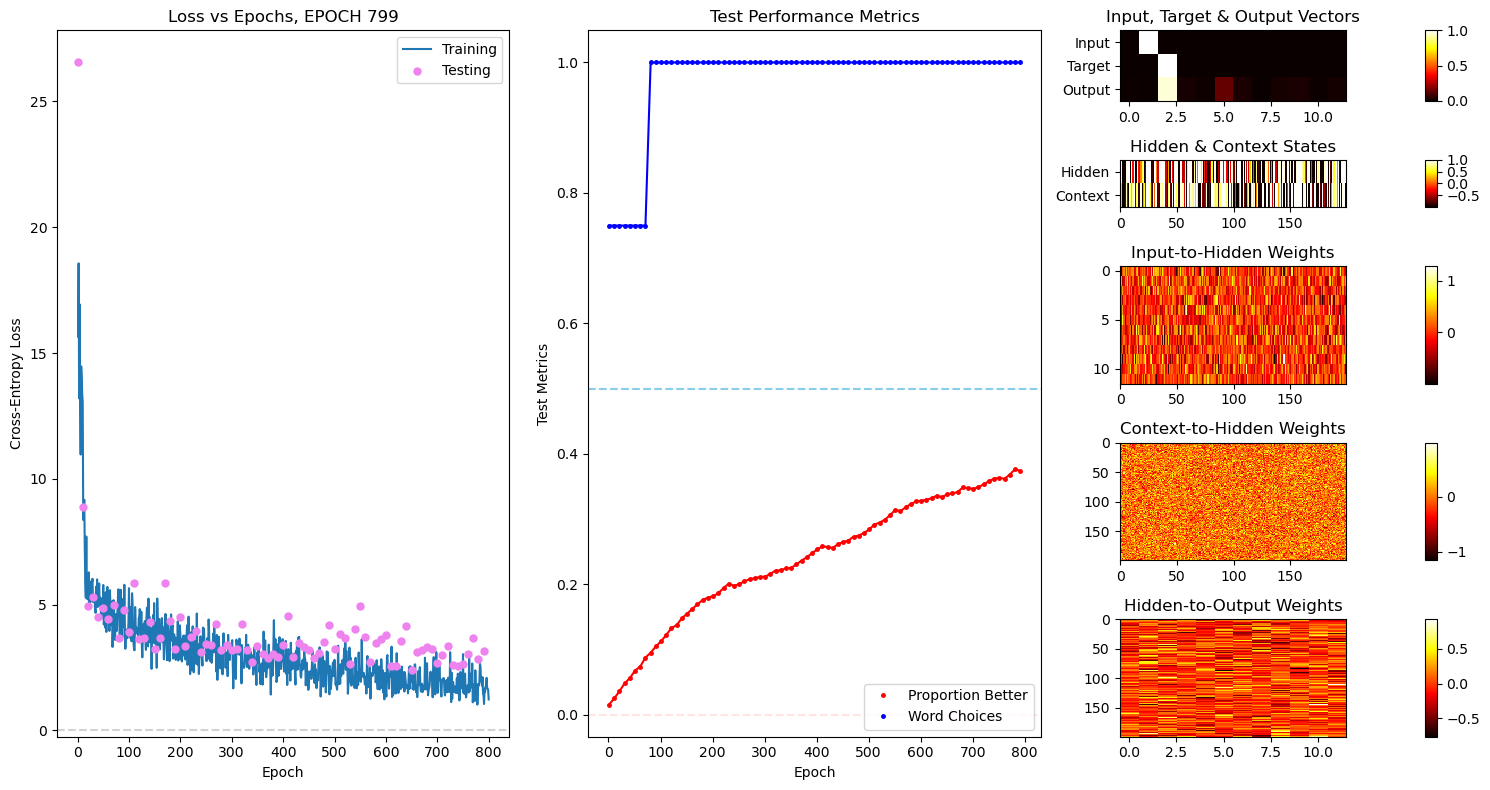

Input: DEFGHIJKLAB	Target: EFGHIJKLABC        
Epoch 799: Test loss 3.1614, Proportion Better 0.3739, Word Choices 1.0000


In [44]:
# Example usage
# Here are 4 'words' akin to the items used by Saffran et al. (1996)
lexicon = ['ABC', 'DEF', 'GHI', 'JKL']
# testlexicon = ['ABC', 'DEF'] # Saffran et al only used the first 2 words
testlexicon=None

# Here are 4 'part-words' made up of the last syllable of 1 word and the first 2 syllables of another
comparison_items = ['CDE', 'FGH', 'IJK', 'LAB']  # Example
# comparison_items = ['IJK', 'AGH']  # Modeled directly after the items used by Saffran et al
# if nhid is set to None, the actual number will be the same as number of unique syllables in lexicon,
# which is the approach of French et al. 2011
#nhid = 2
# nhid = 3
#nhid = 20
nhid = 200
# nhid = None 
W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state = initialize_network(lexicon, \
                                                                                                    nhidden=nhid)
nepochs = 800
W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, hidden_state = \
    train_network(lexicon, nepochs, W_input_hidden, W_bias_hidden, W_context_hidden, W_hidden_output, \
                  hidden_state, print_interval=10, nhidden=nhid, learning_rate=0.005, test_interval=10, \
                  testlexicon=testlexicon)

---

## <font color='red'>Ideas for exploration</font>

1. Try changing the number of hidden nodes. Comment out the line `nhid = None` and uncomment one of the other ones. Try setting `nhid` to 2. Increase `nepochs` to see if the network can learn. (Hint: it's unlikely to get good at this task with 2 hidden nodes.) What's the smallest number of hidden nodes you can specify and have the system learn in reasonable time? What happens if you specify a lot of nodes (30 or 300)? Note that it may also be helpful to increase or decrease the learning rate. 

2. Try eliminating the bias nodes (simplest way: set them to zero initially and comment out the steps that update the bias-to-hidden weights). Does this change things? Does it change how few hidden nodes you can use? 

3. Remove the context nodes (simplest way: intialize the weights to zero and comment out the steps that update context-to-hidden weights). This will make this a feedforward network without memory. Can it still learn this task? 

---

## How we could move something like this to publication

As we'll discuss in class, SRNs were largely dismissed as a good model for human statistical learning due to some famous apparent failures reported ~15 years ago. This means a useful paper would be one that would do a few things. 

1. Train many instances of each model and average results to make sure we are not focused on flukes. In a paper I'm working on, I repeat each simulation 100 times. 

2. Apply SRNs to classic cases like Saffran et al. (1996) but also the cases where people reported they fail. I've done this, and with some corrections to poor procedures in previous work, SRNs work great. 

3. Try to identify which statistical learning tasks really require long-distance dependencies (i.e., more than predicting the next syllable directly from the current one). I found that the early, classic studies (Saffran et al., 1996; Aslin et al., 1998) can be learned by feedforward networks that can only learn adjacent syllable transitional probabilities, but many others require the memory provided by an SRN. My challenge now is figuring out what the actual statistical information acquired by the SRN is in those cases. If this is a challenge you would be interested in learning more about or even working on, let me know!  

